In [4]:
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import time
import math
IOFOLDER='../../DGD_IO/'

In [2]:
def val(P,x):
    return P[0]+P[1]*x+P[2]*x*x
def grad(P,x):
    return P[1]+P[2]*2*x

In [3]:
def find(dsu,i):
    if dsu[i]==i:
        return i
    dsu[i]=find(dsu,dsu[i])
    return dsu[i]
def merge(dsu,i,j):
    dsu[find(dsu,i)]=find(dsu,j)
def connected(G):
    dsu=[i for i in range(len(G))]
    for i in range(len(G)):
        for j in G[i]:
            merge(dsu,i,j)
    for i in range(len(G)):
        if (find(dsu,i)!=find(dsu,0)):
            return (False,dsu)
    return (True,dsu)

In [16]:
#TODO: TEST RANDOM GRAPH FOR MORE VALS OF P
#TODO: ALLOW INPUT TO CONTAIN TESTS OF MULTIPLE VALS OF P
#TODO: TEST EQUIVOCATING ADVERSARY
#parameters/other variables to adjust
tmp=None
Pvals=[0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.25,0.5,1]
params=[[50,Pvals[(i-1)//100],i] for i in range(1,len(Pvals)*100+1)]
    #[[50,[0.2,0.5,1][(i-1)//100],i] for i in range(1,301)]
fin=open(IOFOLDER+'input.txt','w')
for param in params:
    N,P,seed=param
    fin.write('N,P,seed={},{},{}\n'.format(N,P,seed))
    rnd.seed(seed)
    att=0
    while True:
        if P=='line':
            graph=[list(range(max(0,i-1),min(N,i+2))) for i in range(N)]
        else:
            graph=[[] for i in range(N)]
            for i in range(N):
                for j in range(i):
                    if rnd.random()<P:
                        graph[i].append(j)
                        graph[j].append(i)
                graph[i].append(i)
        info=connected(graph)
        att+=1
        if info[0]:
            break
    if seed%10==0:
        print(str(param)+'; # attempts='+str(att))

    #functions
    Ps=[]
    for i in range(N):
        a=rnd.uniform(0,1)
        v=rnd.uniform(-100,100)
        #(ax-v)^2=a^2x^2-2avx+v^2
        Ps.append(np.array([v*v,-2*a*v,a*a]))
    tP=np.array([0.0 for i in range(3)])
    for Pi in Ps:
        tP+=Pi
    tP/=N
    optx=-tP[1]/(2*tP[2])
    optval=val(tP,optx)
    #print(str(optx)+','+str(optval))
    locs0=[rnd.uniform(-200,200) for i in range(N)]
    #print('mean starting loc='+str(np.mean(locs0)))
    
    for i in range(N):
        fin.write(str(i)+':'+str(graph[i])[1:-1].replace(' ','')+'\n')
    for i in range(N):
        fin.write(str(i)+':')
        for j in range(len(Ps[i])):
            fin.write(str(Ps[i][j])+(',' if j<len(Ps[i])-1 else '\n'))
    fin.write(str(locs0)[1:-1].replace(' ','')+'\n')

    #graph network visualization
    '''groups=[[] for i in range(N)]
    for i in range(N):
        groups[find(info[1],i)].append(i)
    seq=[]
    for g in groups:
        seq.extend(g)
    locs=[[] for i in range(N)]
    for i in range(N):
        t=2*math.pi*i/N
        locs[seq[i]]=[math.cos(t),math.sin(t)]
    plt.figure()
    amt=0
    for g in groups:
        if len(g)>0:
            amt+=1
    tmp=0
    for g in groups:
        if len(g)>0:
            col=(1-tmp/amt,0,tmp/amt)
            for i in g:
                for j in graph[i]:
                    plt.plot([locs[i][0],locs[j][0]],[locs[i][1],locs[j][1]],linewidth=1,c=col)
            plt.scatter(x=[locs[i][0] for i in g],y=[locs[i][1] for i in g],s=40,c=[col for i in g])
            tmp+=1'''

fin.close()

[50, 0.05, 10]; # attempts=9
[50, 0.05, 20]; # attempts=12
[50, 0.05, 30]; # attempts=32
[50, 0.05, 40]; # attempts=80
[50, 0.05, 50]; # attempts=33
[50, 0.05, 60]; # attempts=15
[50, 0.05, 70]; # attempts=91
[50, 0.05, 80]; # attempts=176
[50, 0.05, 90]; # attempts=216
[50, 0.05, 100]; # attempts=34
[50, 0.075, 110]; # attempts=1
[50, 0.075, 120]; # attempts=1
[50, 0.075, 130]; # attempts=1
[50, 0.075, 140]; # attempts=1
[50, 0.075, 150]; # attempts=4
[50, 0.075, 160]; # attempts=2
[50, 0.075, 170]; # attempts=3
[50, 0.075, 180]; # attempts=8
[50, 0.075, 190]; # attempts=4
[50, 0.075, 200]; # attempts=1
[50, 0.1, 210]; # attempts=1
[50, 0.1, 220]; # attempts=1
[50, 0.1, 230]; # attempts=2
[50, 0.1, 240]; # attempts=1
[50, 0.1, 250]; # attempts=1
[50, 0.1, 260]; # attempts=1
[50, 0.1, 270]; # attempts=1
[50, 0.1, 280]; # attempts=1
[50, 0.1, 290]; # attempts=2
[50, 0.1, 300]; # attempts=1
[50, 0.125, 310]; # attempts=1
[50, 0.125, 320]; # attempts=1
[50, 0.125, 330]; # attempts=1
[50, 

A,ITER=1,10000


<IPython.core.display.Javascript object>


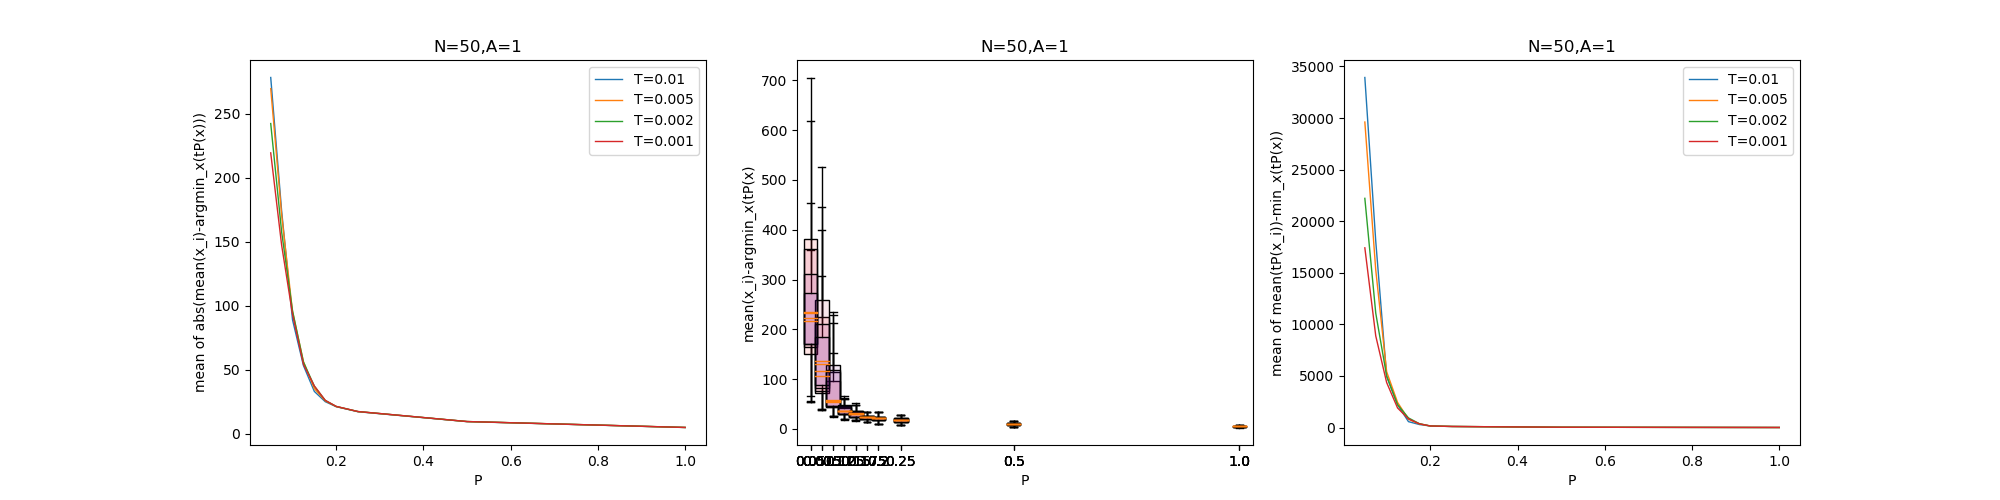

In [22]:
PARSELIST=lambda s:list(map(float,s.split(',')))
info=open(IOFOLDER+'stats_out_A=1.txt','r').read().split('\n')
#print(info)
A,ITER=list(map(int,info[0].split('=')[1].split(',')))
print('A,ITER={},{}'.format(A,ITER))

data={}
param=seed=T=optloc=optscr=None
for i in range(1,len(info)):
    pcs=info[i].split('=')
    if len(pcs)==1:
        continue
    k=pcs[0]
    if k=='N,P,seed':
        split=pcs[1].rindex(',')
        param=pcs[1][:split]
        seed=pcs[1][split+1:]
        if not(param in data):
            data[param]={}
        data[param][seed]={}
    elif k=='T':
        T=pcs[1]
        data[param][seed][T]={}
    elif k=='optloc,optscr':
        optloc,optscr=PARSELIST(pcs[1])
        data[param][seed]['optloc']=optloc
        data[param][seed]['optscr']=optscr
    else:
        data[param][seed][T][k]=PARSELIST(pcs[1])
param=seed=T=optloc=optscr=None

displays={}
for param in data:
    displays[param]={}
    for key in ['meanloc_fin','meandiff_fin']:
        nums={}
        for seed in data[param]:
            for T in data[param][seed]:
                if T!='optloc' and T!='optscr':
                    if not(T in nums):
                        nums[T]=[]
                    nums[T].append(data[param][seed][T][key][0]-data[param][seed]['optloc'])
        displays[param][key]=nums
#print(displays)

fig,(ax,axb,bx)=plt.subplots(1,3,figsize=(20,5))
title='N=50,A='+str(A)#+', equivocating adversary'
ax.set_title(title)
ax.set_xlabel('P')
ax.set_ylabel('mean of abs(mean(x_i)-argmin_x(tP(x)))')
axb.set_title(title)
axb.set_xlabel('P')
axb.set_ylabel('mean(x_i)-argmin_x(tP(x)')
bx.set_title(title)
bx.set_xlabel('P')
bx.set_ylabel('mean of mean(tP(x_i))-min_x(tP(x))')
Tvals=set()
for param in displays:
    for T in displays[param]['meanloc_fin']:
        Tvals.add(T)
Tvals=list(reversed(sorted(list(Tvals))))
idx=0
for T in Tvals:
    xs=[float(param[param.rindex(',')+1:]) for param in displays]
    ax.plot(xs,[np.mean(list(map(abs,displays[param]['meanloc_fin'][T]))) for param in displays],linewidth=1,label='T='+T)
    bxplt=axb.boxplot([displays[param]['meanloc_fin'][T] for param in displays],
                      positions=xs,
                      showfliers=False,
                      patch_artist=True,
                     widths=0.03)#,label='T='+T)
    for patch in bxplt['boxes']:
        patch.set_facecolor((1-idx/len(Tvals),0,idx/len(Tvals),0.1))
    #axb.plot(xs,[np.mean(displays[param][T]) for param in displays],linewidth=1,label='T='+T)
    bx.plot(xs,[np.mean(displays[param]['meandiff_fin'][T]) for param in displays],linewidth=1,label='T='+T)
    idx+=1
ax.legend()
bx.legend()
axb.set_xlim([0.02,1.03])
fig.savefig('tmp.png',bbox_inches='tight')

In [ ]:
#TITLE_PARAM='(N={},P={},A={},'+('simple mean' if A==0 else 'trimmed mean[1:-1]')+')'
fig,mlocfins=plt.subplots(1,2,figsize=(16,5))
findiffs={}
Tvals=set()
for seed in data:
    print('seed='+str(seed))
    print(str([T for T in data[seed]]))
    findiffs[seed]={}
    for T in data[seed]:
        if T!='optloc' and T!='optscr':
            Tvals.add(T)
            findiffs[seed][T]=data[seed][T]['meanloc_fin'][0]-data[seed]['optloc']
print(findiffs)
print(Tvals)
plt.figure()
plt.xlabel('P')
plt.ylabel('mean objective diff')
for T in Tvals:
    plt.scatter(x=[P for seed in data],y=[findiffs[seed][T] for seed in data],label='T='+T)
plt.legend()

'''mlocs.set_title(' mean(x_i) vs. time '+'(seed='+str(seed)+') '+TITLE_PARAM.format(N,P,A))
mlocs.set_xlabel('time (rounds)')
mlocs.set_ylabel('mean(x_i)')
mlocs.plot([0,ITER],[data[seed]['optloc'],data[seed]['optloc']],linewidth=2,c='black')
mdiffs.set_title('mean objective diff vs. time '+'(seed='+str(seed)+') '+TITLE_PARAM.format(N,P,A))
mdiffs.set_xlabel('time (rounds)')
mdiffs.set_ylabel('log10(mean objective diff)')
for T in data[seed]:
    if T!='optloc' and T!='optscr':
        mlocs.plot(data[seed][T]['meanloc'],label='T='+str(T))
        mdiffs.plot(list(map(lambda x:np.log10(x),data[seed][T]['meandiff'])),label='T='+str(T))
mlocs.legend()
mdiffs.legend()
fig.savefig('tmp',bbox_inches='tight')'''

In [ ]:
#old DGD for reference
B=None
F=lambda x:np.mean(x[A:-A])
print('N,P={},{}'.format(N,P))
print('A,ITER={},{}'.format(A,ITER))
fig,axs=plt.subplots(1,2,figsize=(16,5))
TITLE_PARAM='(N,P,A,F)=({},{},{},'+('simple_mean' if A==0 else 'trimmed_mean[1:-1]')+')'
axs[0].set_title('mean objective diff vs. time '+TITLE_PARAM.format(N,P,A))
axs[0].set_xlabel('time (iterations)')
axs[0].set_ylabel('log10(mean objective diff)')

'''axs[1].set_title('functions')
axs[1].set_xlabel('x')
axs[1].set_ylabel('P_i,tP')
tmp=np.linspace(min(locss[ITER])-200,max(locss[ITER])+200,100)
for P in Ps:
    axs[1].plot(tmp,val(P,tmp),alpha=0.1)
axs[1].plot(tmp,val(tP,tmp),linewidth=3)
axs[1].scatter(x=locss[ITER],y=[val(tP,v) for v in locss[ITER]],s=10,c='black')'''

locsTime=axs[1]
locsTime.set_title(' mean(x_i) vs. time '+TITLE_PARAM.format(N,P,A))
locsTime.set_xlabel('time (rounds)')
locsTime.set_ylabel('mean(x_i)')
locsTime.plot([0,ITER],[optx,optx],linewidth=2,c='black')

for T in [0.01,0.005,0.002,0.001]:
    locs=locs0
    locss=[locs]
    for rep in range(ITER):
        receivedVals=[[] for i in range(N)]
        for i in range(N+A):
            for j in (graph[i] if i<N else list(range(N))):
                if j<N:
                    receivedVals[j].append(locs[i] if i<N else 1000000)
                #                                              ^^^^^^^
                #basic adversary: always send the same big number to all neighbors
                #if "always super high": 1000000
                #if "always super low": -1000000
                #if "half high/half low": (1000000 if j<N/2 else -1000000)
        for i in range(N):
            receivedVals[i].sort()
        nlocs=[F(receivedVals[i])-T*grad(Ps[i],locs[i]) for i in range(N)]
        locs=nlocs
        locss.append(locs)
    meanscr=np.mean([val(tP,locss[ITER][i]) for i in range(N)])
    line='{},{},{},{},{},{},{}'.format(N,B,A,T,seed,optval,meanscr)
    print(line)
    axs[0].plot([np.log10(np.mean([val(tP,locss[t][i]) for i in range(N)])-optval) for t in range(ITER+1)],label='T='+str(T))
    
    '''axs[2].set_title('x_i vals over time')
    axs[2].set_xlabel('position')
    axs[2].set_ylabel('x_i')
    for i in range(0,100,1):
        axs[2].plot(locss[i],linewidth=1,alpha=0.1,color=(i/ITER,0,1-i/ITER))
    for i in range(100,ITER+1,10):
        axs[2].plot(locss[i],linewidth=1,alpha=0.1,color=(i/ITER,0,1-i/ITER))'''
    locsTime.plot([np.mean(locss[t]) for t in range(ITER+1)],linewidth=1,label='T='+str(T))
axs[0].legend()
locsTime.legend()
#fig.savefig('tmp',bbox_tight=True)